In [1]:
import subprocess
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.metrics import classification_report
# from imblearn.over_sampling import RandomOverSampler,BorderlineSMOTE,KMeansSMOTE,SVMSMOTE,SMOTE,ADASYN
# from imblearn.pipeline import make_pipeline
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from sklearn import svm
from sklearn.svm import SVC
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
torch.manual_seed(1)
torch.set_deterministic(True)

In [2]:
def download_dataset():
    dataset = "shayanfazeli/heartbeat"
    cur_dir = os.path.dirname(os.path.abspath("__file__"))
    file_name = cur_dir+"/heartbeat.zip"
    if not os.path.isfile(file_name):
        #download the dataset
        subprocess.run("kaggle datasets download -d shayanfazeli/heartbeat".split(" "),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        indx=file_name.find(".zip")
        subprocess.run(["unzip",file_name[:indx]],stderr=subprocess.PIPE,stdout=subprocess.PIPE)
    print("Download Complete")
download_dataset()

Download Complete


In [3]:
def plot_examples(labels,counts,file_name='mitdb.png'):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, counts, width, label='Class Distribution')
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts',fontsize=22)
    ax.set_title('Classes',fontsize=22)
    ax.set_xticks(x)
    
    


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for indx,rect in enumerate(rects):
            height = counts[indx]
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=22)


    autolabel(rects1)

    fig.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(file_name)
    #plt.show()

Class 0 4046 Examples
Class 1 10506 Examples


(14552,)

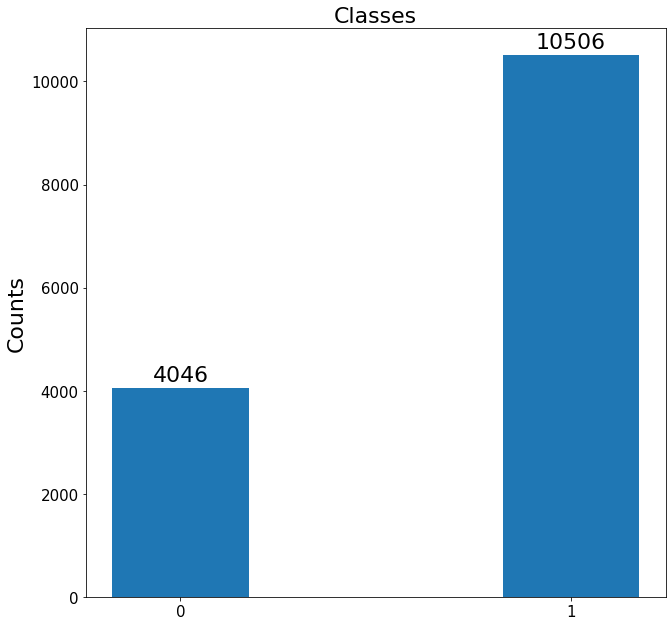

In [4]:
train_data_ab = np.genfromtxt('ptbdb_abnormal.csv', delimiter=',')
train_data_normal = np.genfromtxt('ptbdb_normal.csv', delimiter=',')
label_types = [0,1]
examples_per_class=[train_data_normal.shape[0],train_data_ab.shape[0]]

for indx,values in enumerate(label_types):
    print("Class {0} {1} Examples".format(int(values),examples_per_class[indx]))

plot_examples(label_types,examples_per_class,file_name='ptdb.png')

train_data=np.append(train_data_ab,train_data_normal,axis=0)
#np.random.shuffle(train_data)
assert train_data.shape[0]==sum(examples_per_class)

train_data,train_labels=train_data[:,:-1],train_data[:,-1]
train_labels.shape

In [5]:
def test_train_split(X,Y,random_state=1,split=0.8):
    return train_test_split(X,Y,train_size=split,stratify=Y)

train_data,test_data,train_labels,test_labels=test_train_split(train_data,train_labels)
test_labels=test_labels.astype('int32')
train_labels=train_labels.astype('int32')

In [6]:
def get_priors(y):
    num_classes=np.unique(y)
    
    priors=[]
    for values in num_classes:
        priors.append(np.sum(y==values)/y.shape[0])
    return priors
        
#A wrapper class to be passed into sklearn pipeline
class NBWrapper:
    def __init__(self):
        self.gnb=None
    def fit(self,train_data,train_labels):
        self.gnb=GaussianNB()
        self.gnb.fit(train_data,train_labels)
    def predict(self,test_data):
        assert self.gnb!=None
        return self.gnb.predict(test_data)
    def report_accuracy(self,truth,pred):
        return classification_report(truth,pred)
    def do_everything(self,test_data,test_labels):
        pred=self.predict(test_data)
        return self.report_accuracy(test_labels,pred)
    def transform(self):
        raise NotImplementedError

def gaussian_nb(train_data,train_labels):
    validator=StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
    gnb=GaussianNB()
    score=cross_val_score(gnb,train_data,train_labels,cv=validator)
    score=sum(score)/score.shape[0]
    gnb.fit(train_data,train_labels)
    return score,gnb,"Gaussian Naive Bayes"


score,clf,name=gaussian_nb(train_data,train_labels)
pred=clf.predict(test_data)
print(classification_report(test_labels,pred))

              precision    recall  f1-score   support

           0       0.41      0.85      0.55       809
           1       0.90      0.53      0.67      2102

    accuracy                           0.62      2911
   macro avg       0.66      0.69      0.61      2911
weighted avg       0.76      0.62      0.64      2911



In [ ]:

"""
Come back later
def apply_imbalanced_learn(wrapper):
    #resample everything but the majority class
    samplers=[RandomOverSampler(random_state=0),SMOTE(random_state=0),ADASYN(random_state=0),BorderlineSMOTE(random_state=0),KMeansSMOTE(random_state=0),SVMSMOTE(random_state=0)]
    for sampler in samplers:
        #sampler.fit()
        pipe=make_pipeline(sampler,wrapper)
        pipe.fit(train_data,train_labels)
        report=wrapper.do_everything(test_data,test_labels)
        print(report)
        
apply_imbalanced_learn(NBWrapper())
"""

In [9]:
def tune_hyper_params_dt(train_data,train_labels):
    diff_depths=[3,5,7,9,12,15,18,None]
    max_depth_sol=None
    max_f1_score=float("-inf")
    for values in diff_depths:
        #print(values)
        validator=StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
        clf = tree.DecisionTreeClassifier(max_depth=values,random_state=0)
        score=cross_val_score(clf,train_data,train_labels,scoring='f1',cv=validator)
        score=sum(score)/len(score)
        if score>max_f1_score:
            max_depth_sol=values
            max_f1_score=score
    return max_f1_score,max_depth_sol    
        
    
def train_decision_tree(train_data,train_labels):
    score,max_depth=tune_hyper_params_dt(train_data,train_labels)
    clf=tree.DecisionTreeClassifier(random_state=0,max_depth=max_depth)
    clf.fit(train_data,train_labels)
    print("max_depth,score",max_depth,score)
    return score,clf,"Decision Tree"
 
score,clf,name=train_decision_tree(train_data,train_labels)
pred=clf.predict(test_data)
report=classification_report(test_labels,pred)
print(report)

max_depth,score None 0.9383256707946567
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       809
           1       0.95      0.94      0.95      2102

    accuracy                           0.92      2911
   macro avg       0.90      0.91      0.90      2911
weighted avg       0.92      0.92      0.92      2911



In [57]:
#  Note this takes a while to finish
# selecting best kernel
def best_model(train_data,train_labels):
    models = ['linear', 'rbf', 'poly', 'sigmoid']
    C_VALS=[1,4,16,64,100]
    best_kernel = None
    max_f1_score=float("-inf")
    best_c_value=None
    for kernel in models:
        #print("Kernel",kernel)
        for values in C_VALS:
            #print("C value",values)
            validator=StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
            clf = svm.SVC(kernel = kernel,gamma='scale',C=values)
            score=cross_val_score(clf,train_data,train_labels,scoring='f1',cv=validator)
            score=sum(score)/len(score)
            if score>max_f1_score:
                best_kernel = kernel
                max_f1_score = score
                best_c_value=values
    return best_kernel,max_f1_score,best_c_value

# training the model using best kernel
def train_svm(train_data,train_labels):
    best_kernel,f1_score,best_c_value = best_model(train_data, train_labels)
    print("best_kernel:{0} f1_score:{1} C-Values:{2}".format(best_kernel, f1_score, best_c_value))
    clf = svm.SVC(kernel = best_kernel,gamma='scale',C=best_c_value)
    classifier = clf.fit(train_data,train_labels)
    return f1_score,classifier,"SVM with {0} Kernel".format(best_kernel)


#clf = svm.SVC(kernel = "rbf",gamma='scale',C=100)
#classifier = clf.fit(train_data,train_labels)

"""
_,clf,_ = train_svm(train_data,train_labels)
pred = clf.predict(test_data)
report=classification_report(test_labels,pred)
print(report)
"""

'\n_,clf,_ = train_svm(train_data,train_labels)\npred = clf.predict(test_data)\nreport=classification_report(test_labels,pred)\nprint(report)\n'

In [25]:
def cnn_model(train_data,test_data,train_labels,test_labels,epochs,batch_size):
    
    train_data,train_val,y_train,y_val = train_test_split(train_data,train_labels)
    
#     numeric to categorical conversion
    num_classes = len(np.unique(test_labels))
    test_op = test_labels.copy()
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    test_labels = keras.utils.to_categorical(test_labels, num_classes) 
    

    train_data = train_data.reshape(train_data.shape[0], train_data.shape[1],1)
    test_data = test_data.reshape(test_data.shape[0], test_data.shape[1],1)
    train_val = train_val.reshape(train_val.shape[0], train_val.shape[1],1)
    y_val = y_val.reshape(y_val.shape[0], y_val.shape[1],1)
    
#    defining the Model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(187,1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
#     training the model
    model.fit(train_data, y_train, epochs=epochs, batch_size=batch_size, validation_data=(train_val, y_val))
    accuracy = model.evaluate(test_data, test_labels, batch_size = batch_size)
    print("\n")
    print("accuracy for test_data",accuracy)

#     prediction
    pred = model.predict_classes(test_data)
    report = classification_report(test_op,pred)
    print("\n")
    print(report)
    
    return model
    

batch_size = 32
epochs = 20
model = cnn_model(train_data, test_data,train_labels,test_labels, epochs, batch_size)

Epoch 1/20
342/342 [==============================] - 6s 18ms/step - loss: 0.3866 - accuracy: 0.8125 - val_loss: 0.3159 - val_accuracy: 0.8851
Epoch 2/20
342/342 [==============================] - 6s 18ms/step - loss: 0.2778 - accuracy: 0.8835 - val_loss: 0.2373 - val_accuracy: 0.9175
Epoch 3/20
342/342 [==============================] - 6s 17ms/step - loss: 0.2025 - accuracy: 0.9184 - val_loss: 0.1620 - val_accuracy: 0.9461
Epoch 4/20
342/342 [==============================] - 6s 19ms/step - loss: 0.1534 - accuracy: 0.9428 - val_loss: 0.1514 - val_accuracy: 0.9439
Epoch 5/20
342/342 [==============================] - 6s 17ms/step - loss: 0.1389 - accuracy: 0.9493 - val_loss: 0.1248 - val_accuracy: 0.9610
Epoch 6/20
342/342 [==============================] - 6s 19ms/step - loss: 0.1102 - accuracy: 0.9570 - val_loss: 0.1074 - val_accuracy: 0.9621
Epoch 7/20
342/342 [==============================] - 6s 17ms/step - loss: 0.1043 - accuracy: 0.9612 - val_loss: 0.1055 - val_accuracy: 0.9676

In [28]:
def select_models():
    models=[]
    models_to_obj_name={}
    model_funcs=[train_decision_tree,gaussian_nb,train_svm]
    for funcs in model_funcs:
        models.append(funcs(train_data,train_labels))
        models_to_obj_name[models[-1][-2]]=models[-1][-1]

    models.sort(key=lambda x:x[0])
    #print(models,models_to_obj_name)
    return models[-1][-2],models[-1][-1]
    
model,name=select_models()
print("Best Fit so Far {0}".format(name))
pred=model.predict(test_data)
report=classification_report(pred,test_labels)
print(report)

max_depth,score 18 0.9398100636891694
best_kernel:rbf f1_score:0.978304899562376 C-Values:100
Best Fit so Far SVM with rbf Kernel
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       807
         1.0       0.98      0.98      0.98      2104

    accuracy                           0.97      2911
   macro avg       0.97      0.97      0.97      2911
weighted avg       0.97      0.97      0.97      2911



In [50]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 4, 3)
        self.bn1=nn.BatchNorm1d(4)
        
        self.conv2 = nn.Conv1d(4, 16, 3)
        self.bn2=nn.BatchNorm1d(16)
        
        """
        self.conv3 = nn.Conv1d(64, 256, 3)
        self.bn3=nn.BatchNorm1d(256)
        """
        
        self.fc1 = nn.Linear(16*45, 50)
        self.fc2 = nn.Linear(50, 2)
        #self.predict=nn.Softmax(dim=1)
        
    def forward(self, x):
        #x=F.dropout(F.avg_pool1d(F.relu(self.bn1(self.conv1(x))),2),p=0.25)
        #x=F.dropout(F.avg_pool1d(F.relu(self.bn2(self.conv2(x))),2),p=0.25)
        x=F.avg_pool1d(F.relu(self.bn1(self.conv1(x))),2)
        
        x=F.avg_pool1d(F.relu(self.bn2(self.conv2(x))),2)
        
        
        #print(x.size())
        #x=F.dropout(F.avg_pool1d(F.relu(self.bn3(self.conv3(x))),2),p=0.5)
        
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    def features_extract(self,x):
        x=F.avg_pool1d(F.relu(self.bn1(self.conv1(x))),2)
        x=F.avg_pool1d(F.relu(self.bn2(self.conv2(x))),2)
        x = x.view(-1, self.num_flat_features(x))
        return x
        
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            #print(s)
            num_features *= s
        return num_features

Class 0 72471 Examples
Class 1 15083 Examples


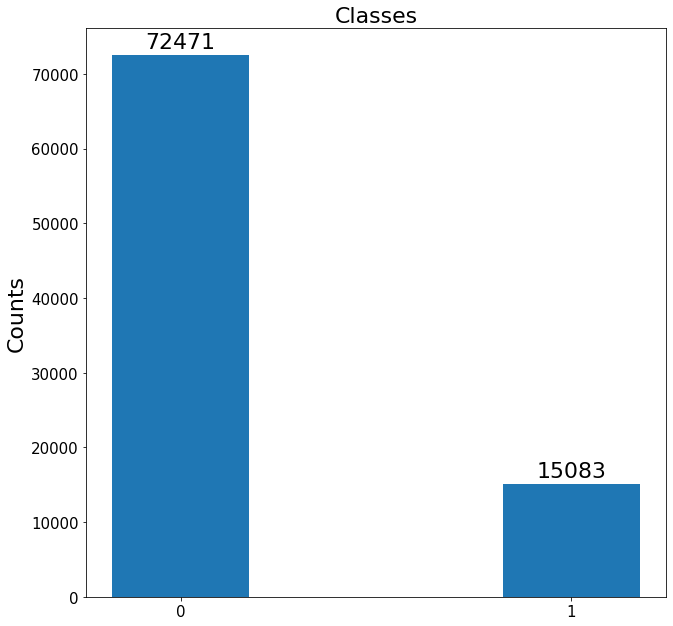

In [12]:
train_data_mit = np.genfromtxt('mitbih_train.csv', delimiter=',')
test_data_mit=np.genfromtxt('mitbih_test.csv',delimiter=",")

indices=train_data_mit[:,-1]!=0.0
train_data_mit[indices,-1]=1.0

indices=test_data_mit[:,-1]!=0.0
test_data_mit[indices,-1]=1.0
#print(test_data_mit)
#test_label_types=np.unique(test_data_mit[:,-1])
#print(test_label_types)
"""
for values in test_label_types:
    print("Class {0} {1} Examples".format(int(values),np.sum(test_data_mit[:,-1]==values)))
    print(np.sum(test_data_mit[:,-1]==values))
    #examples_per_class.append(np.sum(train_data_mit[:,-1]==values))
#print(np.unique(test_data_mit[:,-1]))
"""

label_types = np.unique(train_data_mit[:,-1])
examples_per_class=[]

for values in label_types:
    print("Class {0} {1} Examples".format(int(values),np.sum(train_data_mit[:,-1]==values)))
    examples_per_class.append(np.sum(train_data_mit[:,-1]==values))

plot_examples(label_types,examples_per_class)

In [13]:
#Train validation split for ot
#print(train_data_mit.shape)
train_data_mit,train_labels_mit=train_data_mit[:,:-1],train_data_mit[:,-1]
#print(train_data_mit.shape,train_labels_mit.shape)
train_data_mit,cv_data_mit,train_labels_mit,cv_labels_mit=test_train_split(train_data_mit,train_labels_mit)

train_data_mit=np.append(train_data_mit,train_labels_mit.reshape((train_labels_mit.shape[0],1)),axis=1)
cv_data_mit=np.append(cv_data_mit,cv_labels_mit.reshape((cv_labels_mit.shape[0],1)),axis=1)

In [16]:
def init(weights=None):
    net=CNN()
    loss=nn.CrossEntropyLoss(weight=weights)
    _optim=optim.Adam(net.parameters(),lr=0.01)
    return net,loss,_optim

In [24]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

def test_results(model,testloader,output_dict=False):
    with torch.no_grad():
        all_preds=[]
        all_labels=[]
        for _,test_data in enumerate(testloader,0):
            test_data,test_labels=test_data[:,:-1],test_data[:,-1]
            test_data=test_data.view(-1,1,test_data.size()[1])
            #print(test_data.size())
            outputs=model(test_data.double())
            _,pred=torch.max(outputs,1)
            pred=pred.to(torch.double)
            test_labels=test_labels.to(torch.double)
            all_preds.extend(pred.tolist())
            all_labels.extend(list(test_labels))
        
    report=classification_report(all_labels,all_preds,output_dict=output_dict)
    return report,np.unique(all_labels)        
    
torch.backends.cudnn.benchmark = False

weights=(max(examples_per_class)*1.0)/torch.Tensor(examples_per_class)

batch_size=256
dataloader=DataLoader(train_data_mit,shuffle=True,batch_size=batch_size,worker_init_fn=seed_worker)
testloader=DataLoader(test_data_mit,batch_size=batch_size,worker_init_fn=seed_worker)
valloader=DataLoader(cv_data_mit,batch_size=cv_data_mit.shape[0],worker_init_fn=seed_worker)

epochs=10
#model=model.double()
print_every=10

def get_best_model(num_epochs=5,trials=5):
    max_f1_score=float("-inf")
    best_model=None
    for trial in range(trials):
        model,loss,_optim=init(weights=weights.double())
        model=model.double()
        #print(loss.weights)
        for epoch in range(num_epochs):
            for batch_no,train_data in enumerate(dataloader,0):
                train_data,train_labels=train_data[:,:-1],train_data[:,-1]
                train_data=train_data.view(-1,1,train_data.size()[1])
                outputs=model(train_data.double())
                _optim.zero_grad()
                loss_func=loss(outputs,train_labels.long())
                loss_func.backward()
                _optim.step()
        print("Trial,",trial)
        report,labels=test_results(model.eval(),valloader,output_dict=True)
        f1_score=0.0
        for values in labels:
            #print(report,values)
            #print(type(report))
            f1_score+=report[str(values)]["f1-score"]
        if max_f1_score<(f1_score/(float(labels.shape[0]))):
            max_f1_score=(f1_score/(float(labels.shape[0])))
            best_model=model
    return best_model,max_f1_score
        


model,score=get_best_model()
print(score)
print(test_results(model.eval(),valloader)[0])
_optim=optim.Adam(model.parameters(),lr=0.01)

Trial, 0
Trial, 1
Trial, 2
Trial, 3
Trial, 4
0.9556071403958584
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     14494
         1.0       0.92      0.93      0.93      3017

    accuracy                           0.97     17511
   macro avg       0.95      0.96      0.96     17511
weighted avg       0.97      0.97      0.97     17511



In [31]:
model=CNN()
model.load_state_dict(torch.load("best_cnn/best_binary_model_after_trials.pt"))
_optim=optim.Adam(model.parameters(),lr=0.01)

In [32]:
#Now let's early stop
patience=5
loss=nn.CrossEntropyLoss(weight=weights)
loss.double()
best_model=model
model.double()
max_f1_score=score
num_epochs=20
improvement=0
for epoch in range(num_epochs):
    for batch_no,train_data in enumerate(dataloader,0):
        train_data,train_labels=train_data[:,:-1],train_data[:,-1]
        train_data=train_data.view(-1,1,train_data.size()[1])
        outputs=model(train_data.double())
        _optim.zero_grad()
        loss_func=loss(outputs,train_labels.long())
        loss_func.backward()
        _optim.step()
    
    report,labels=test_results(model.eval(),valloader,output_dict=True)
    f1_score=0.0
    for values in labels:
        f1_score+=report[str(values)]["f1-score"]

    if max_f1_score<(f1_score/(float(labels.shape[0]))):
        max_f1_score=(f1_score/(float(labels.shape[0])))
        best_model=model
        improvement=0
    else:
        improvement+=1
        
    if improvement==patience:
        break

report,_ = test_results(best_model.eval(),testloader)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     18118
         1.0       0.91      0.95      0.93      3774

    accuracy                           0.97     21892
   macro avg       0.95      0.96      0.95     21892
weighted avg       0.97      0.97      0.97     21892



In [33]:
PATH = "best_cnn/best_binary_model.pt"
torch.save(best_model.state_dict(), PATH)

In [51]:
best_model=CNN()
best_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Class 0 4046 Examples
Class 1 10506 Examples


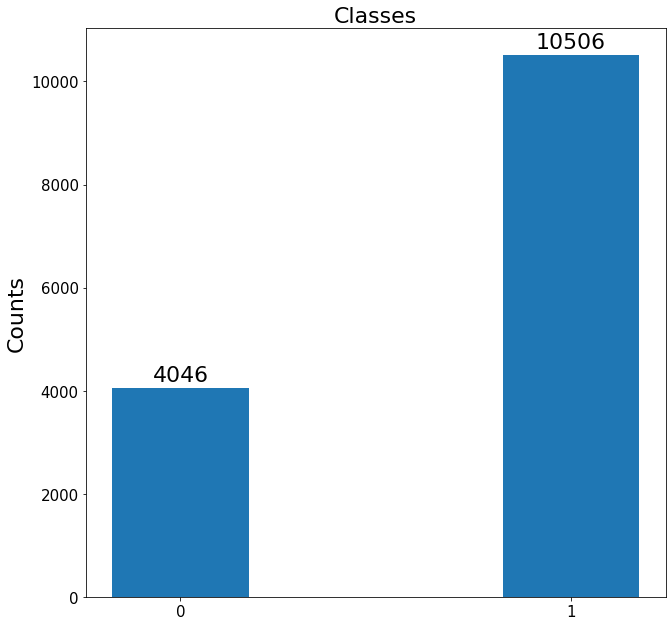

In [52]:
train_data_ab = np.genfromtxt('ptbdb_abnormal.csv', delimiter=',')
train_data_normal = np.genfromtxt('ptbdb_normal.csv', delimiter=',')
label_types = [0,1]
examples_per_class=[train_data_normal.shape[0],train_data_ab.shape[0]]

for indx,values in enumerate(label_types):
    print("Class {0} {1} Examples".format(int(values),examples_per_class[indx]))

plot_examples(label_types,examples_per_class,file_name='ptdb.png')

train_data=np.append(train_data_ab,train_data_normal,axis=0)
#np.random.shuffle(train_data)
assert train_data.shape[0]==sum(examples_per_class)

train_data,train_labels=train_data[:,:-1],train_data[:,-1]

In [53]:
train_data,test_data,train_labels,test_labels=test_train_split(train_data,train_labels)
test_labels=test_labels.astype('int32')
train_labels=train_labels.astype('int32')

In [54]:
models=[best_model]
batch_size=512
ptb_train_loader=DataLoader(train_data,batch_size=batch_size)
extracted_features=[]

aug_features=[]
for model in models:
    data_feat=None
    for _,values in enumerate(ptb_train_loader,0):
        model.eval()
        model.double()
        values=values.view(-1,1,values.size()[-1])
        with torch.no_grad():
            model.eval()
            feats=model.features_extract(values)
            if data_feat is None:
                data_feat=np.array(feats.numpy())
            else:
                data_feat=np.vstack((data_feat,feats.numpy()))
    aug_features.append(data_feat)

train_data=aug_features[0]

In [55]:
print(train_data.shape)

(11641, 720)


In [58]:
#_,clf,_ = train_svm(train_data,train_labels)

testloader
pred = clf.predict(test_data)
report=classification_report(test_labels,pred)
print(report)

best_kernel:rbf f1_score:0.9895413737191738 C-Values:16


ValueError: X.shape[1] = 187 should be equal to 720, the number of features at training time

In [62]:
batch_size=512
ptb_train_loader=DataLoader(test_data,batch_size=batch_size)
model.eval()
data_feat=None

for _,values in enumerate(ptb_train_loader,0):
    model.eval()
    model.double()
    values=values.view(-1,1,values.size()[-1])
    with torch.no_grad():
        model.eval()
        feats=model.features_extract(values)
        if data_feat is None:
            data_feat=np.array(feats.numpy())
        else:
            data_feat=np.vstack((data_feat,feats.numpy()))

In [65]:
pred=clf.predict(data_feat)
report=classification_report(test_labels,pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       809
           1       0.99      0.99      0.99      2102

    accuracy                           0.99      2911
   macro avg       0.98      0.98      0.98      2911
weighted avg       0.99      0.99      0.99      2911

